In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
import re
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
seeds = ["10","20"]
tempos = ["25hosts","50hosts","75hosts","100hosts"]
salvarGraficos = False
confianca = 95
#intervalosTempo = [("cargaAlta", 100, 200), ("cargaMedia", 300, 400), ("cargaBaixa", 550, 650)]

In [3]:
#Arquivos de log de bloqueios
bloqueio_d = pd.DataFrame()
bloqueio_e = pd.DataFrame()
for seed in seeds:
    for tempo in tempos:
        bloqueio_dtemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-regrasBloqueadas.txt", sep="\s+")
        bloqueio_etemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-regrasBloqueadas.txt", sep="\s+")
        bloqueio_dtemp['Seed'] = seed
        bloqueio_etemp['Seed'] = seed
        bloqueio_etemp['TempoChegada'] = tempo
        bloqueio_dtemp['TempoChegada'] = tempo
        bloqueio_dtemp['Politica'] = 'Dinamica'
        bloqueio_etemp['Politica'] = 'Estatica'
        bloqueio_d = pd.concat([bloqueio_d, bloqueio_dtemp], ignore_index=True)
        bloqueio_e = pd.concat([bloqueio_e, bloqueio_etemp], ignore_index=True)

dfBloq = pd.concat([bloqueio_d, bloqueio_e], ignore_index=True)
del dfBloq['Time']

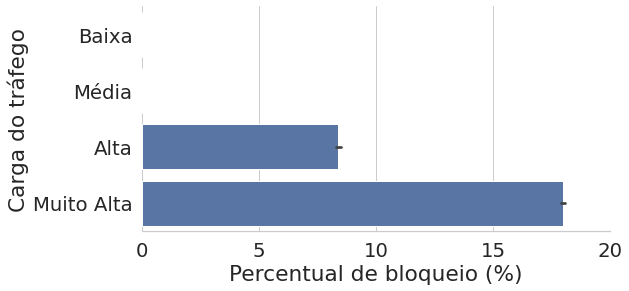

In [4]:
#Grafico de percentual de bloqueio
gpb = dfBloq.groupby(["Seed", "TempoChegada", "Politica"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = (gpb["RegrasBloqueadas"]/(gpb["RegrasBloqueadas"]+gpb["RegrasAceitas"]))*100
gpb["NomeTempo"] = gpb["TempoChegada"].map({"75hosts": "Alta", "50hosts": "Média", "25hosts": "Baixa","100hosts": "Muito Alta"})
#display (gpb) 
sns_plt = sns.catplot(legend=False, height=4.5, aspect=2, x="TaxaBloqueio", y="NomeTempo", kind="bar", orient="h", hue="Politica", hue_order=["Estatica"],order=["Baixa", "Média", "Alta", "Muito Alta"], ci=confianca, data=gpb)
#sns_plt.fig.suptitle('Taxa de bloqueio por carga', y=1.05)
sns_plt.set(xlim=(0, 20))
sns_plt.set_axis_labels("Percentual de bloqueio (%)","Carga do tráfego")
sns_plt.despine(left=True)

In [5]:
#Lendo os arquivos de ping
def pings(dfP, metodo, switch):
    for s in range(len(seeds)):
        for tempo in tempos:
            path = "logs/seed"+(str((s+1)*10))+"/"+(tempo)+"/"+(metodo)+"/"+(tempo)+(metodo)+"-"+(str((s+1)*10))+"-ping"+switch+".txt" #caminho do arquivo
            with open(path) as stream:#Abre o arquivo
                times = [] #lista que armazenara todos os pings para coloca-los posteriormente em um series->dataframe
                seqs = []
                next(stream)  # Ignora a primeira linha do arquivo de entrada
                for line in stream: #Pega todas as linhas
                    string = line.split(" ") #String eh uma lista com cada palavra da linha
                    if(line != "Request timed out\n"): #Se a linha tiver o ping
                        for i in range(0,len(string)): #Para cada palavra na lista string, procura "time"
                            if(re.match(r'time', string[i])): #Pega somente os valores numericos da palavra
                                time = re.findall(r'\d.+', string[i])
                                times.append(float(time[0]))
                            if(re.match(r'seq', string[i])): #Pega somente os valores numericos da palavra
                                seq = re.findall(r'[0-9]+', string[i])
                                seqs.append(float(seq[0]))
                series = pd.Series(times) #Transforma a lista em uma Series
                series1 = pd.Series(seqs)
                ds = pd.DataFrame(series, columns=['Ping']) # E por fim em um dataframe
                ds['Seed'] = seeds[s]
                ds['Tempo'] = tempo
                ds['Política'] = metodo
                ds['Switch'] = switch
                ds = ds.assign(Seq=pd.Series(seqs).values)
                dfP = pd.concat([dfP, ds])
    return dfP

dfPing = pd.DataFrame(columns=['Ping', 'Seed', 'Tempo', 'Política', 'Switch'])
dfPPIHW = pings(dfPing, 'Estatica', 'HW')
dfPPISW = pings(dfPing, 'Estatica', 'SW')
dfPSWHW = pings(dfPing, 'Dinamica', 'HW')
dfPSWSW = pings(dfPing, 'Dinamica', 'SW')
dfPing = pd.concat([dfPing, dfPPIHW, dfPPISW, dfPSWHW, dfPSWSW])
dfPing.reset_index(inplace=True)
del dfPing['index']
#dfPing.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')

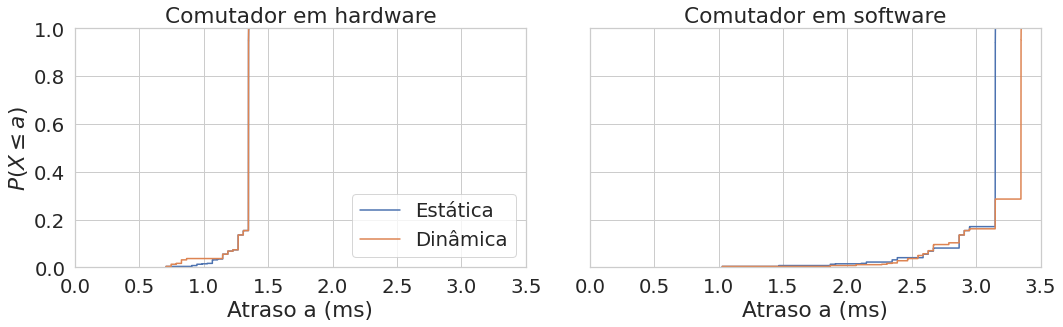

In [6]:
#CDF do ping
#Query
dfPingHW_CAPI = dfPing.query("Política == 'Estatica' and Tempo == '100hosts' and Switch == 'HW'")
dfPingHW_CASW = dfPing.query("Política == 'Dinamica' and Tempo == '100hosts' and Switch == 'HW'")
dfPingSW_CAPI = dfPing.query("Política == 'Estatica' and Tempo == '100hosts' and Switch == 'SW'")
dfPingSW_CASW = dfPing.query("Política == 'Dinamica' and Tempo == '100hosts' and Switch == 'SW'")
#HW
hw_a = dfPingHW_CAPI.Ping.to_numpy()
hw_b = dfPingHW_CASW.Ping.to_numpy()
maxHW = [hw_a.max(), hw_b.max()]
hw_x = np.sort(hw_a)
hw_x1 = np.sort(hw_b)
hw_ecdf = sm.distributions.ECDF(hw_a)
hw_ecdf1 = sm.distributions.ECDF(hw_b)
hw_y = hw_ecdf(hw_x)
hw_y1 = hw_ecdf1(hw_x1)
#SW
sw_a = dfPingSW_CAPI.Ping.to_numpy()
sw_b = dfPingSW_CASW.Ping.to_numpy()
maxSW = [sw_a.max(), sw_b.max()]
sw_x = np.sort(sw_a)
sw_x1 = np.sort(sw_b)
sw_ecdf = sm.distributions.ECDF(sw_a)
sw_ecdf1 = sm.distributions.ECDF(sw_b)
sw_y = sw_ecdf(sw_x)
sw_y1 = sw_ecdf1(sw_x1)
#Graficos
#HW
plt.subplot(1, 2, 1)
plt.step(hw_x, hw_y, where='post', label="Estática")
plt.step(hw_x1, hw_y1, where='post', label="Dinâmica")
plt.ylabel(r'$P(X \leq a)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 3.5)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Comutador em hardware')
maiorPing = np.max(maxHW)
# plt.annotate('Até '+str(maxHW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85),size='x-large',
#             arrowprops=dict(facecolor='#587bb4', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
# plt.annotate('Até '+str(maxHW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7),size='x-large',
#             arrowprops=dict(facecolor='#e09163', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
#SW
plt.subplot(1, 2, 2)
plt.step(sw_x, sw_y, where='post', label="Estática")
plt.step(sw_x1, sw_y1, where='post', label="Dinâmica")
#plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 3.5)
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Comutador em software')
#Tamanho
fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.tight_layout()
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
maiorPing = np.max(maxSW)
# plt.annotate('Até '+str(maxSW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85), size='x-large',
#             arrowprops=dict(facecolor='#587bb4', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
# plt.annotate('Até '+str(maxSW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7), size='x-large',
#             arrowprops=dict(facecolor='#e09163', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
if (salvarGraficos):
    plt.savefig('Graficos/pingCargaAlta.pdf')
plt.show()

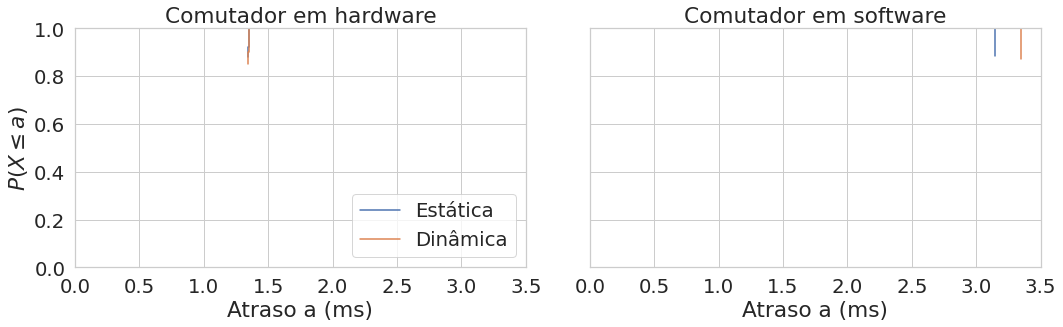

In [7]:
#CDF do dfPing no intervalo estável
dfPing.query("Seq >= 150.0 and Seq <= 250.0", inplace=True)
#Query
dfPingHW_CAPI = dfPing.query("Política == 'Estatica' and Tempo == '100hosts' and Switch == 'HW'")
dfPingHW_CASW = dfPing.query("Política == 'Dinamica' and Tempo == '100hosts' and Switch == 'HW'")
dfPingSW_CAPI = dfPing.query("Política == 'Estatica' and Tempo == '100hosts' and Switch == 'SW'")
dfPingSW_CASW = dfPing.query("Política == 'Dinamica' and Tempo == '100hosts' and Switch == 'SW'")
#HW
hw_a = dfPingHW_CAPI.Ping.to_numpy()
hw_b = dfPingHW_CASW.Ping.to_numpy()
maxHW = [hw_a.max(), hw_b.max()]
hw_x = np.sort(hw_a)
hw_x1 = np.sort(hw_b)
hw_ecdf = sm.distributions.ECDF(hw_a)
hw_ecdf1 = sm.distributions.ECDF(hw_b)
hw_y = hw_ecdf(hw_x)
hw_y1 = hw_ecdf1(hw_x1)
#SW
sw_a = dfPingSW_CAPI.Ping.to_numpy()
sw_b = dfPingSW_CASW.Ping.to_numpy()
maxSW = [sw_a.max(), sw_b.max()]
sw_x = np.sort(sw_a)
sw_x1 = np.sort(sw_b)
sw_ecdf = sm.distributions.ECDF(sw_a)
sw_ecdf1 = sm.distributions.ECDF(sw_b)
sw_y = sw_ecdf(sw_x)
sw_y1 = sw_ecdf1(sw_x1)
#Graficos
#HW
plt.subplot(1, 2, 1)
plt.step(hw_x, hw_y, where='post', label="Estática")
plt.step(hw_x1, hw_y1, where='post', label="Dinâmica")
plt.ylabel(r'$P(X \leq a)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 3.5)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Comutador em hardware')
maiorPing = np.max(maxHW)
# plt.annotate('Até '+str(maxHW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85),size='x-large',
#             arrowprops=dict(facecolor='#587bb4', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
# plt.annotate('Até '+str(maxHW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7),size='x-large',
#             arrowprops=dict(facecolor='#e09163', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
#SW
plt.subplot(1, 2, 2)
plt.step(sw_x, sw_y, where='post', label="Estática")
plt.step(sw_x1, sw_y1, where='post', label="Dinâmica")
#plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Atraso a (ms)')
plt.xlim(0, 3.5)
plt.ylim(0, 1)
#plt.legend(loc='best')
plt.title('Comutador em software')
#Tamanho
fig = plt.gcf()
fig.set_size_inches(15, 5)
fig.tight_layout()
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
maiorPing = np.max(maxSW)
# plt.annotate('Até '+str(maxSW[1])+' ms', xy=(2, 0.85), xytext=(1.8, 0.85), size='x-large',
#             arrowprops=dict(facecolor='#587bb4', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
# plt.annotate('Até '+str(maxSW[0])+' ms', xy=(2, 0.7), xytext=(1.8, 0.7), size='x-large',
#             arrowprops=dict(facecolor='#e09163', shrink=0.05),
#             horizontalalignment='right', verticalalignment='bottom')
if (salvarGraficos):
    plt.savefig('Graficos/pingCargaAltaNoIntervaloEstavel.pdf')
plt.show()

In [8]:
dfHW_e = pd.DataFrame()
dfSW_e = pd.DataFrame()
dfHW_d = pd.DataFrame()
dfSW_d = pd.DataFrame()
for seed in seeds:
    for tempo in tempos: 
        dfHW_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
        dfSW_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
        dfHW_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-switch-stats-hw.log", sep="\s+")
        dfSW_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-switch-stats-sw.log", sep="\s+")
        dfHW_eTemp['Seed'] = seed
        dfSW_eTemp['Seed'] = seed
        dfHW_dTemp['Seed'] = seed
        dfSW_dTemp['Seed'] = seed
        dfHW_eTemp['TempoChegada'] = tempo
        dfSW_eTemp['TempoChegada'] = tempo
        dfHW_dTemp['TempoChegada'] = tempo
        dfSW_dTemp['TempoChegada'] = tempo
        dfHW_eTemp['Politica'] = 'Estatica'
        dfSW_eTemp['Politica'] = 'Estatica'
        dfHW_dTemp['Politica'] = 'Dinamica'
        dfSW_dTemp['Politica'] = 'Dinamica'
        dfHW_e = pd.concat([dfHW_e, dfHW_eTemp], ignore_index=True)
        dfSW_e = pd.concat([dfSW_e, dfSW_eTemp], ignore_index=True)
        dfHW_d = pd.concat([dfHW_d, dfHW_dTemp], ignore_index=True)
        dfSW_d = pd.concat([dfSW_d, dfSW_dTemp], ignore_index=True)

remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_e[item]
    del dfSW_e[item]
    del dfHW_d[item]
    del dfSW_d[item]
dfHW_e['Switch'] = 'HW'
dfSW_e['Switch'] = 'SW'
dfHW_d['Switch'] = 'HW'
dfSW_d['Switch'] = 'SW'
dfSwitch_e = pd.concat([dfHW_e, dfSW_e], ignore_index=True)
dfSwitch_d = pd.concat([dfHW_d, dfSW_d], ignore_index=True)
dfSwitches = pd.concat([dfSwitch_e, dfSwitch_d], ignore_index=True)
dfSwitches.query("TimeSec >= 150 and TimeSec <= 250", inplace=True)
# dfSwitches

In [9]:
gpb = dfSwitches.groupby(["Politica", "TempoChegada", "Switch", "Seed"]).mean()
gpb.reset_index(inplace=True)
# gpb

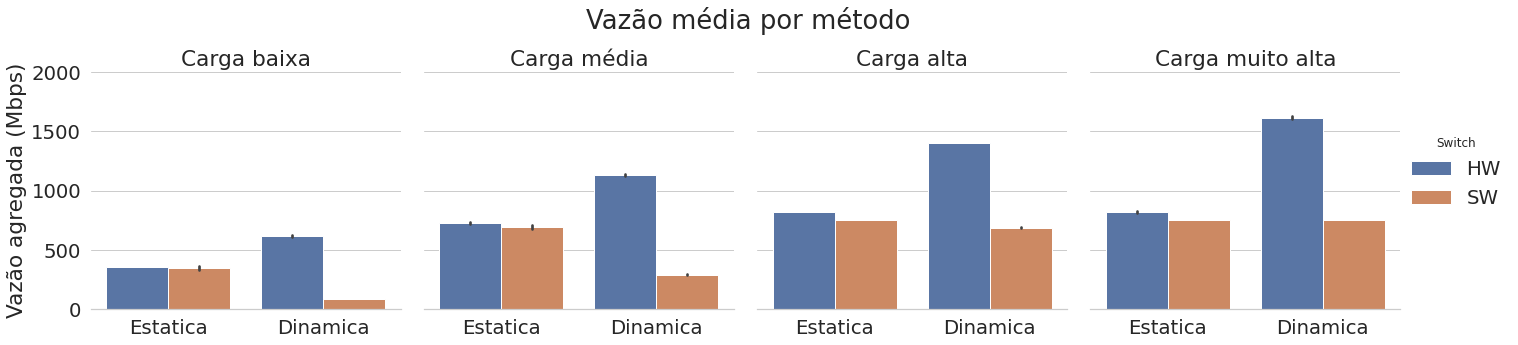

In [10]:
gpb["NomeTempo"] = gpb["TempoChegada"].map({"100hosts": "muito alta","75hosts": "alta", "50hosts": "média", "25hosts": "baixa"})
gpb["LoaKbps"] = gpb["LoaKbps"]/1000
sns_plt = sns.catplot(x="Politica", y="LoaKbps", kind="bar", ci=95, data=gpb, col="NomeTempo", col_order=["baixa", "média","alta","muito alta"], order=["Estatica", "Dinamica"], hue="Switch")
sns_plt.set(ylim=(0, 2000))
sns_plt.fig.suptitle('Vazão média por método', y=1.05)
sns_plt.set_axis_labels("", "Vazão agregada (Mbps)")
sns_plt.set_titles("Carga {col_name}")
sns_plt.despine(left=True)

In [11]:
gpbM = gpb.groupby(['TempoChegada','Switch','Politica']).mean()
display(gpbM['LoaKbps'])

TempoChegada  Switch  Politica
100hosts      HW      Dinamica    1613.733028
                      Estatica     821.514237
              SW      Dinamica     749.999984
                      Estatica     750.000044
25hosts       HW      Dinamica     616.750668
                      Estatica     356.392528
              SW      Dinamica      87.548750
                      Estatica     347.906891
50hosts       HW      Dinamica    1128.794828
                      Estatica     727.895323
              SW      Dinamica     293.133180
                      Estatica     691.990799
75hosts       HW      Dinamica    1402.559212
                      Estatica     820.360756
              SW      Dinamica     687.616914
                      Estatica     749.999984
Name: LoaKbps, dtype: float64

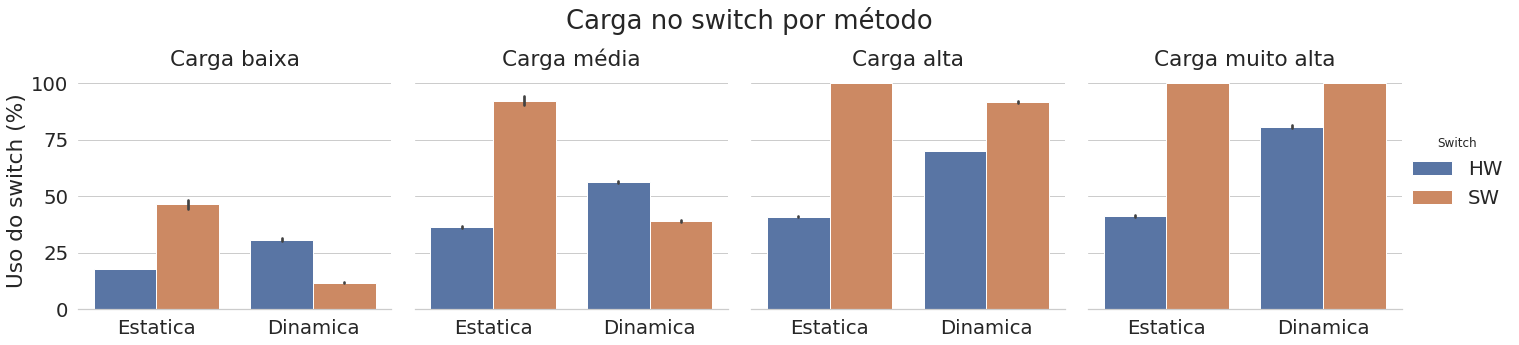

In [12]:
#gpb1 = dfSwitches.groupby(["Politica", "TempoChegada", "Switch", "Seed"]).mean()
#gpb1.reset_index(inplace=True)
#gpb1["NomeTempo"] = gpb1["TempoChegada"].map({"75hosts": "alta", "50hosts": "média", "25hosts": "baixa"})
sns_plt = sns.catplot(x="Politica", y="LoaUsag", kind="bar", ci=95, data=gpb, col="NomeTempo", col_order=["baixa", "média","alta","muito alta"], order=["Estatica", "Dinamica"], hue="Switch")
#sns_plt.set(ylim=(0, 100))
sns_plt.fig.suptitle('Carga no switch por método', y=1.05)
sns_plt.set_axis_labels("", "Uso do switch (%)")
sns_plt.set_titles("Carga {col_name}")
sns_plt.despine(left=True)

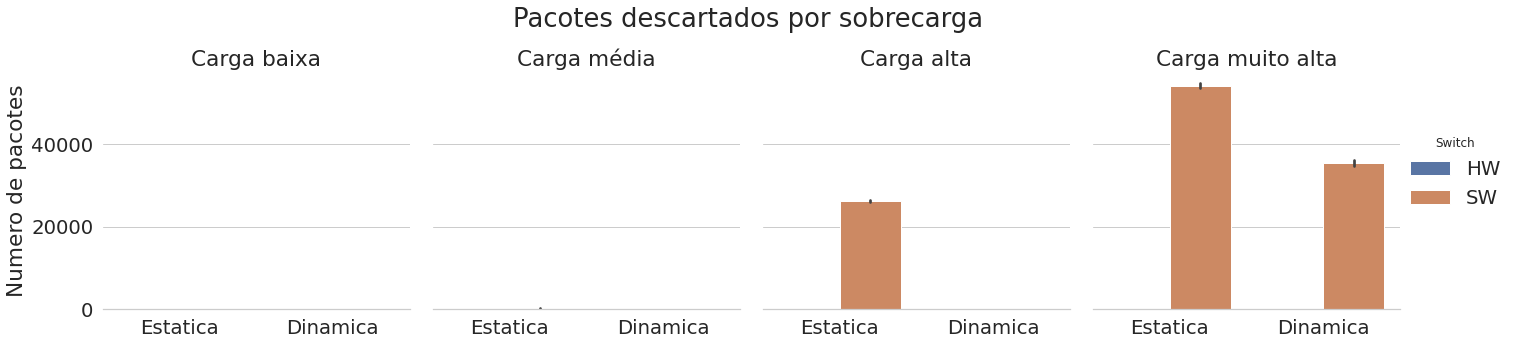

In [13]:
sns_plt = sns.catplot(x="Politica", y="LoaDrps", kind="bar", ci=95, data=gpb, col="NomeTempo", col_order=["baixa", "média","alta","muito alta"], order=["Estatica", "Dinamica"], hue="Switch")
#sns_plt.set(ylim=(0, 1500))
sns_plt.fig.suptitle('Pacotes descartados por sobrecarga', y=1.05)
sns_plt.set_axis_labels("", "Numero de pacotes")
sns_plt.set_titles("Carga {col_name}")
sns_plt.despine(left=True)

In [14]:
gpbM = gpb.groupby(['TempoChegada','Switch','Politica']).mean()
display(gpbM['LoaDrps'])

TempoChegada  Switch  Politica
100hosts      HW      Dinamica        0.000000
                      Estatica        0.000000
              SW      Dinamica    35520.886139
                      Estatica    54126.519802
25hosts       HW      Dinamica        0.000000
                      Estatica        0.000000
              SW      Dinamica        0.000000
                      Estatica        0.000000
50hosts       HW      Dinamica        0.000000
                      Estatica        0.000000
              SW      Dinamica        0.000000
                      Estatica      168.361386
75hosts       HW      Dinamica        0.000000
                      Estatica        0.000000
              SW      Dinamica        0.000000
                      Estatica    26144.381188
Name: LoaDrps, dtype: float64

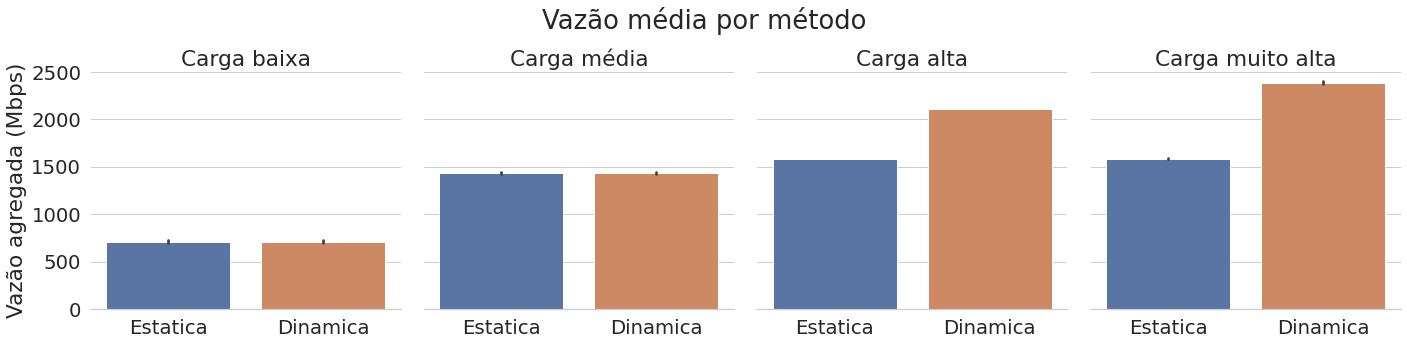

In [15]:
gpb2 = dfSwitches.groupby(["Politica", "TempoChegada", "Seed"]).sum()
gpb2.reset_index(inplace=True)
gpb2["NomeTempo"] = gpb2["TempoChegada"].map({"100hosts": "muito alta","75hosts": "alta", "50hosts": "média", "25hosts": "baixa"})
gpb2["LoaKbps"] = gpb2["LoaKbps"]/100000
# gpb2
sns_plt = sns.catplot(x="Politica", y="LoaKbps", kind="bar", ci=95, data=gpb2, col="NomeTempo", col_order=["baixa", "média","alta","muito alta"], order=["Estatica", "Dinamica"])
sns_plt.set(ylim=(0, 2500))
sns_plt.fig.suptitle('Vazão média por método', y=1.05)
sns_plt.set_axis_labels("", "Vazão agregada (Mbps)")
sns_plt.set_titles("Carga {col_name}")
sns_plt.despine(left=True)

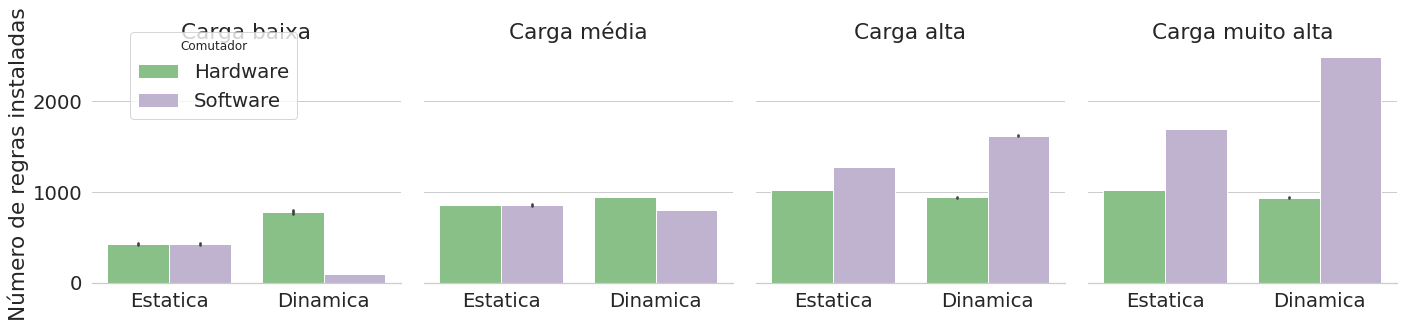

In [16]:
gpb3 = dfSwitches.groupby(["Politica", "TempoChegada", "Switch", "Seed"]).mean()
gpb3.reset_index(inplace=True)
gpb3["NomeSwitch"] = gpb3["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb3["NomeTempo"] = gpb3["TempoChegada"].map({"100hosts": "muito alta","75hosts": "alta", "50hosts": "média", "25hosts": "baixa"})
#Plotando o grafico
sns_plt = sns.catplot(palette="Accent", x="Politica", y="FloEntr", kind="bar", ci=95, data=gpb3, col="NomeTempo", hue="NomeSwitch", col_order=["baixa", "média", "alta","muito alta"], order=["Estatica", "Dinamica"])
#sns_plt.set(ylim=(0, 1000))
#sns_plt.fig.suptitle('Média de regras instaladas por switch no intervalo estável', y=1.05)
sns_plt.set_axis_labels("", "Número de regras instaladas")
sns_plt.set_titles("Carga {col_name}")
sns_plt._legend.set_title("Comutador")
sns_plt.despine(left=True)
leg = sns_plt._legend
leg.set_bbox_to_anchor([0.075, 0.85])
leg._loc = 2
leg.set_frame_on(True)

In [17]:
gpbM = gpb.groupby(['TempoChegada','Switch','Politica']).mean()
display(gpbM['FloEntr'])

TempoChegada  Switch  Politica
100hosts      HW      Dinamica     939.168317
                      Estatica    1021.628713
              SW      Dinamica    2494.168317
                      Estatica    1696.460396
25hosts       HW      Dinamica     780.856436
                      Estatica     426.301980
              SW      Dinamica      94.346535
                      Estatica     427.321782
50hosts       HW      Dinamica     940.737624
                      Estatica     858.262376
              SW      Dinamica     800.742574
                      Estatica     857.603960
75hosts       HW      Dinamica     940.391089
                      Estatica    1019.801980
              SW      Dinamica    1622.920792
                      Estatica    1272.000000
Name: FloEntr, dtype: float64

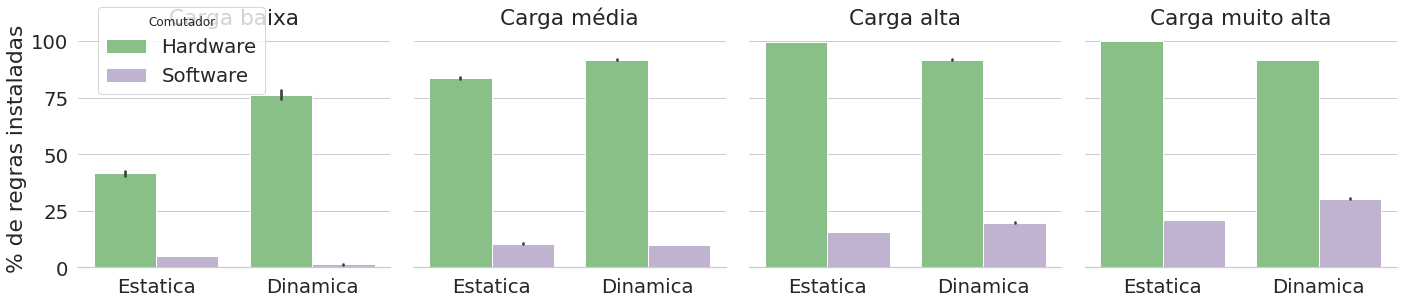

In [18]:
sns_plt = sns.catplot(palette="Accent", x="Politica", y="FloUsag", kind="bar", ci=95, data=gpb3, col="NomeTempo", hue="NomeSwitch", col_order=["baixa", "média", "alta", "muito alta"], order=["Estatica", "Dinamica"])
#sns_plt.set(ylim=(0, 1000))
#sns_plt.fig.suptitle('Média de regras instaladas por switch no intervalo estável', y=1.05)
sns_plt.set_axis_labels("", "% de regras instaladas")
sns_plt.set_titles("Carga {col_name}")
sns_plt._legend.set_title("Comutador")
sns_plt.despine(left=True)
leg = sns_plt._legend
leg.set_bbox_to_anchor([0.055, 0.85])
leg._loc = 2
leg.set_frame_on(True)

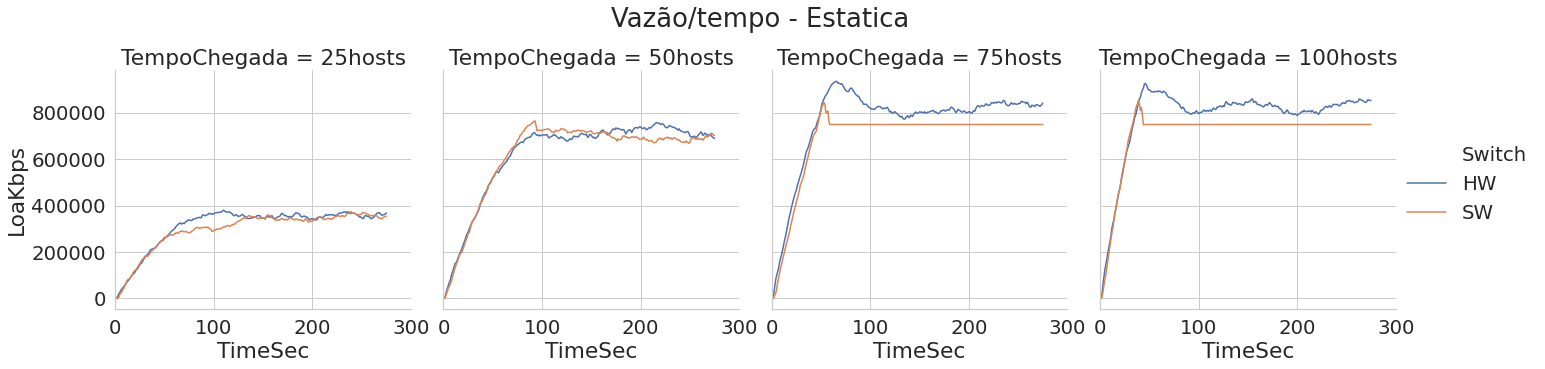

In [19]:
snsplt = sns.relplot(x="TimeSec", y="LoaKbps",
            hue="Switch", col="TempoChegada",
            kind="line", legend="full", data=dfSwitch_e, ci=None)
snsplt.fig.suptitle('Vazão/tempo - Estatica', y=1.05)
snsplt.set(xlim=(0,300))

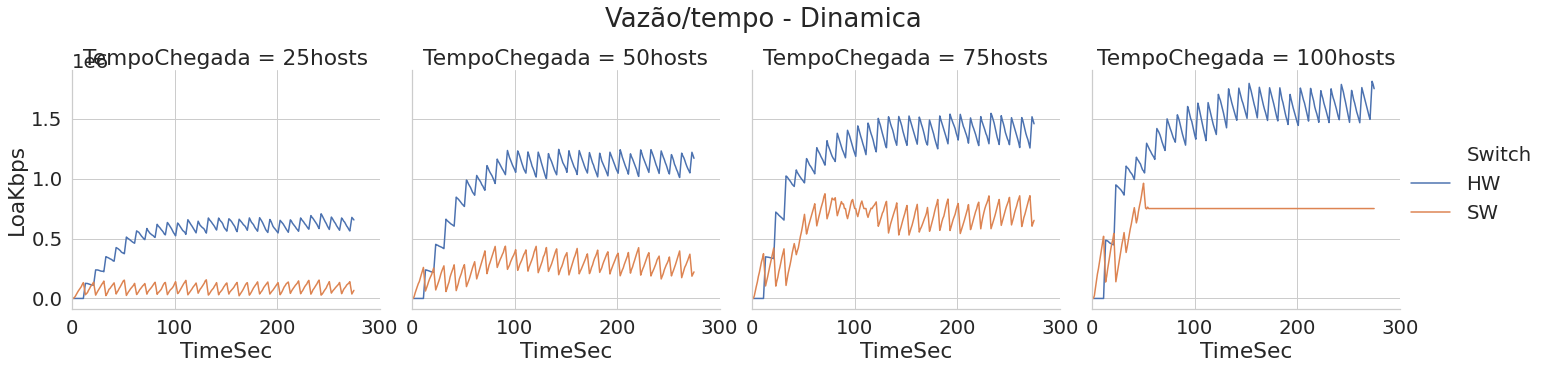

In [20]:
snsplt = sns.relplot(x="TimeSec", y="LoaKbps",
            hue="Switch", col="TempoChegada",
            kind="line", legend="full", data=dfSwitch_d, ci=None)
snsplt.fig.suptitle('Vazão/tempo - Dinamica', y=1.05)
snsplt.set(xlim=(0,300))

In [21]:
dfMuitoAlta = pd.DataFrame()
dfAlta = pd.DataFrame()
dfMedia = pd.DataFrame()
dfBaixa = pd.DataFrame()
#010dinamica-10-traffic-qos-l7-app.log
for seed in seeds:
    for tempo in tempos:
        if (tempo == "100hosts"):
            dfMuitoAlta_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfMuitoAlta_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfMuitoAlta_eTemp['Metodo'] = 'Estatica'
            dfMuitoAlta_dTemp['Metodo'] = 'Dinamica'
            dfMuitoAlta = pd.concat([dfMuitoAlta, dfMuitoAlta_eTemp, dfMuitoAlta_dTemp], ignore_index=True)
        if (tempo == "75hosts"):
            dfAlta_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfAlta_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfAlta_eTemp['Metodo'] = 'Estatica'
            dfAlta_dTemp['Metodo'] = 'Dinamica'
            dfAlta = pd.concat([dfAlta, dfAlta_eTemp, dfAlta_dTemp], ignore_index=True)
        if (tempo == "50hosts"):
            dfMedia_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfMedia_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfMedia_eTemp['Metodo'] = 'Estatica'
            dfMedia_dTemp['Metodo'] = 'Dinamica'
            dfMedia = pd.concat([dfMedia, dfMedia_eTemp, dfMedia_dTemp], ignore_index=True)
        if (tempo == "25hosts"):
            dfBaixa_eTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Estatica/"+tempo+"Estatica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfBaixa_dTemp = pd.read_table("logs/seed"+(seed)+"/"+tempo+"/Dinamica/"+tempo+"Dinamica-"+(seed)+"-traffic-qos-l7-app.log", sep="\s+")
            dfBaixa_eTemp['Metodo'] = 'Estatica'
            dfBaixa_dTemp['Metodo'] = 'Dinamica'
            dfBaixa = pd.concat([dfBaixa, dfBaixa_eTemp, dfBaixa_dTemp], ignore_index=True)

dfMuitoAlta.rename(columns={'Time:s':'Time'}, inplace=True)
dfMuitoAlta.rename(columns={'Loss:%':'Loss'}, inplace=True)
dfAlta.rename(columns={'Time:s':'Time'}, inplace=True)
dfAlta.rename(columns={'Loss:%':'Loss'}, inplace=True)
dfMedia.rename(columns={'Time:s':'Time'}, inplace=True)
dfMedia.rename(columns={'Loss:%':'Loss'}, inplace=True)
dfBaixa.rename(columns={'Time:s':'Time'}, inplace=True)
dfBaixa.rename(columns={'Loss:%':'Loss'}, inplace=True)

dfMuitoAlta.query("Time >= 150 and Time <= 250", inplace=True)
dfMuitoAlta.reset_index(inplace=True)
dfAlta.query("Time >= 150 and Time <= 250", inplace=True)
dfAlta.reset_index(inplace=True)
dfMedia.query("Time >= 150 and Time <= 250", inplace=True)
dfMedia.reset_index(inplace=True)
dfBaixa.query("Time >= 150 and Time <= 250", inplace=True)
dfBaixa.reset_index(inplace=True)
#for index, row in dfAlta.iterrows():
#    if (row['Ul/Dl'] == 'Dlink'):
#        dfAlta.drop(index, inplace=True)
#        
#for index, row in dfMedia.iterrows():
#    if (row['Ul/Dl'] == 'Dlink'):
#        dfMedia.drop(index, inplace=True)
#
#for index, row in dfBaixa.iterrows():
#    if (row['Ul/Dl'] == 'Dlink'):
#        dfBaixa.drop(index, inplace=True)

#dfAlta

In [22]:
#Perda de pacotes no intervalo estavel
#Carga muito alta
print ("Porcentagem de perda carga muito alta:")
min = dfMuitoAlta.groupby("Metodo").min()['Loss']
med = dfMuitoAlta.groupby("Metodo").mean()['Loss']
max = dfMuitoAlta.groupby("Metodo").max()['Loss']
medi = dfMuitoAlta.groupby("Metodo").median()['Loss']
table = [min, med, medi, max]
rowIDs = ["Mínimo", "Média","Mediana", "Máximo"]
print(tabulate(table, headers=["Dinâmica","Estática"], showindex=rowIDs, tablefmt="grid"))

#Carga alta
print ("Porcentagem de perda carga alta:")
min = dfAlta.groupby("Metodo").min()['Loss']
med = dfAlta.groupby("Metodo").mean()['Loss']
max = dfAlta.groupby("Metodo").max()['Loss']
medi = dfAlta.groupby("Metodo").median()['Loss']
table = [min, med, medi, max]
rowIDs = ["Mínimo", "Média","Mediana", "Máximo"]
print(tabulate(table, headers=["Dinâmica","Estática"], showindex=rowIDs, tablefmt="grid"))

#Carga media
print ("Porcentagem de perda carga media:")
min = dfMedia.groupby("Metodo").min()['Loss']
med = dfMedia.groupby("Metodo").mean()['Loss']
max = dfMedia.groupby("Metodo").max()['Loss']
medi = dfMedia.groupby("Metodo").median()['Loss']
table = [min, med, medi, max]
rowIDs = ["Mínimo", "Média","Mediana", "Máximo"]
print(tabulate(table, headers=["Dinâmica","Estática"], showindex=rowIDs, tablefmt="grid"))

#Carga baixa
print ("Porcentagem de perda carga baixa:")
min = dfBaixa.groupby("Metodo").min()['Loss']
med = dfBaixa.groupby("Metodo").mean()['Loss']
max = dfBaixa.groupby("Metodo").max()['Loss']
medi = dfBaixa.groupby("Metodo").median()['Loss']
table = [min, med, medi, max]
rowIDs = ["Mínimo", "Média","Mediana", "Máximo"]
print(tabulate(table, headers=["Dinâmica","Estática"], showindex=rowIDs, tablefmt="grid"))


Porcentagem de perda carga muito alta:
+---------+------------+------------+
|         |   Dinâmica |   Estática |
+=========+============+============+
| Mínimo  |     0      |     0      |
+---------+------------+------------+
| Média   |    39.8768 |    43.3066 |
+---------+------------+------------+
| Mediana |    36.496  |    46.0865 |
+---------+------------+------------+
| Máximo  |   100      |   100      |
+---------+------------+------------+
Porcentagem de perda carga alta:
+---------+------------+------------+
|         |   Dinâmica |   Estática |
+=========+============+============+
| Mínimo  |     0      |     0      |
+---------+------------+------------+
| Média   |    16.4257 |    24.7445 |
+---------+------------+------------+
| Mediana |     0      |    29.032  |
+---------+------------+------------+
| Máximo  |    98.511  |   100      |
+---------+------------+------------+
Porcentagem de perda carga media:
+---------+------------+------------+
|         |   Dinâmi